In [1]:
import networkx as nx
import dynetx as dn

import pickle
import glob

import numpy as np
import pandas as pd

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

In [2]:
def read_pickled_object(filename):
    with open(filename, 'rb') as inp:
        obj = pickle.load(inp)
    return obj

## Analysis

In [3]:
def plot_graph_mpl(G):

    # Get node coordinates and edge weights for contacts inside the cell only
    node_positions = {node: data['coordinates'] for node, data in G.nodes(data=True)}
    edges = [(node1, node2, data)
             for node1, node2, translation, data in G.edges(data=True, keys=True)
             if translation == (0, 0, 0)]

    # Create 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes with annotations
    for node, pos in node_positions.items():
        ax.scatter(pos[0], pos[1], pos[2], color='navy', s=120)
        ax.text(pos[0], pos[1], pos[2], str(node), color='white', fontsize=9, ha='center',
                # bbox=dict(facecolor='white', edgecolor='none', alpha=0.85)
               )

    # Plot edges with varying widths based on weight attribute
    for edge in edges:
        node1, node2, data = edge
        pos1 = node_positions[node1]
        pos2 = node_positions[node2]
        weight = data['weight']
        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], [pos1[2], pos2[2]], linewidth=5*weight, color='black')

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Scatter Plot with Edges')

In [4]:
class TemporalNetworkAnalysis:

    def __init__(self, data_list: list):

        G_list = [data['G'] for data in data_list]
        nodes_list = [pd.DataFrame(data['nodes_data']) for data in data_list]

        self.dG = self._create_dynamic_graph(G_list)
        self.__G0 = G_list[0] # first graph in a list used for dynamic graph construction
        self._create_weighted_static_graph()
        self._collect_nodes_list_data(nodes_list)

    def _create_dynamic_graph(self, G_list):
        """
        Create dynamic graph object from a list of snapshot graphs
        """
        dynamic_G = dn.DynGraph()
        for i, snapshot_G in enumerate(G_list):
            dynamic_G.add_interactions_from(snapshot_G.edges(data=True), t=i)

        return dynamic_G

    def _create_weighted_static_graph(self):
        """
        Create static representation of the dynamic graph as a weighted graph
        """
        self.wsG = self.__G0.copy()

        self._econtributions = [(e, self.dG.edge_contribution(*e)) for e in self.dG.edges]
        weights_dict = {(e[0], e[1]): c for e, c in self._econtributions} | {(e[1], e[0]): c for e, c in self._econtributions}

        for edge in self.wsG.edges(keys=True):
            n1, n2, translation = edge
            weight = weights_dict.get((n1, n2), None)
            if weight is not None:
                self.wsG.add_edge(n1, n2, key=translation, weight=weight)
            else:
                print(edge, '!!!')

    def _collect_nodes_list_data(self, nodes_list):
        """
        Combine the node VDP characteristics from each frame into a single dataframe
        """
        df = pd.concat(nodes_list, axis=1).T
        df = df.astype({
            'frame': 'int32',
            'neigbours_SA_CV': 'float',
            'N_direct_neigbours': 'int8',
            'N_indirect_neigbours': 'int8',
            'N_neigbours': 'int8',
            'MCN': 'float',
            })
        self.node_characteristics = df

    def show_edge_contribution_info(self, plot_edge_weigts=True, return_persistence_df=False):
        """
        Show data on the edge persistence
        """
        df = pd.DataFrame(self._econtributions, columns=['edge', 'p']).sort_values(by='p', ascending=False)

        if plot_edge_weigts:
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)
            df['p'].hist(bins=40, density=False, ax=ax1)
            ax1.set_title('Edge persistence histogram')
            ax1.set_xlabel('persistence')
            ax1.set_xlim(-0.01, 1.01)
            data_sorted = np.sort(df['p'].values)
            y = np.arange(len(data_sorted)) / len(data_sorted)
            ax2.set_title('Edge persistence CDF')
            ax2.plot(data_sorted, y, 'k-', lw=2.5)
            ax2.set_xlabel('persistence')
            plt.show()

        if return_persistence_df:
            return df

    def get_filtered_weighted_static_graph(self, edge_weight_threshold=0.9):
        """
        Return graph with edges filtered to have weight >= edge_weight_threshold.
        Nodes are taken from the first snapshot graph in the G_list
        """

        filtered_wsG = self.wsG.copy()
        filtered_wsG.remove_edges_from(list(filtered_wsG.edges()))

        for edge in self.wsG.edges(keys=True, data=True):
            n1, n2, translation, data = edge
            if data['weight'] >= edge_weight_threshold:
                filtered_wsG.add_edge(n1, n2, key=translation, weight=data['weight'])

        return filtered_wsG

In [5]:
data_list = read_pickled_object('MDTopAnalysis_glucmdc_620K.nxg') # MDTopAnalysis_py1mdc MDTopAnalysis_water_md MDTopAnalysis_benzoquinone MDTopAnalysis_water_md_full MDTopAnalysis_glucmdc_420K

In [6]:
tn_analysis = TemporalNetworkAnalysis(data_list)

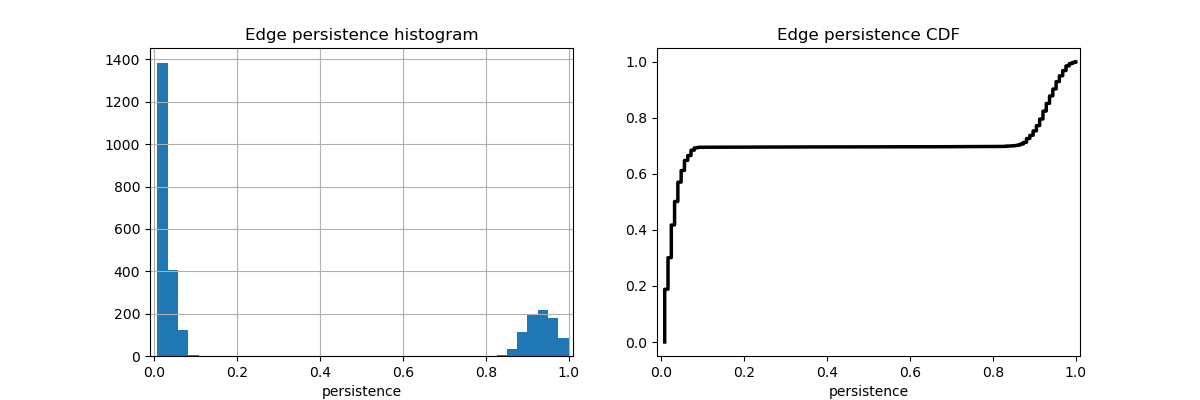

In [7]:
tn_analysis.show_edge_contribution_info(plot_edge_weigts=True, return_persistence_df=False)

In [8]:
ROLLING_MEAN_PERIODS = 15
N_FRAMES = tn_analysis.node_characteristics['frame'].unique()

df_vdp_mean_std =  tn_analysis.node_characteristics.groupby('frame')[
    ['neigbours_SA_CV', 'N_direct_neigbours', 'N_indirect_neigbours', 'N_neigbours', 'MCN']
].agg(['mean', 'std'])

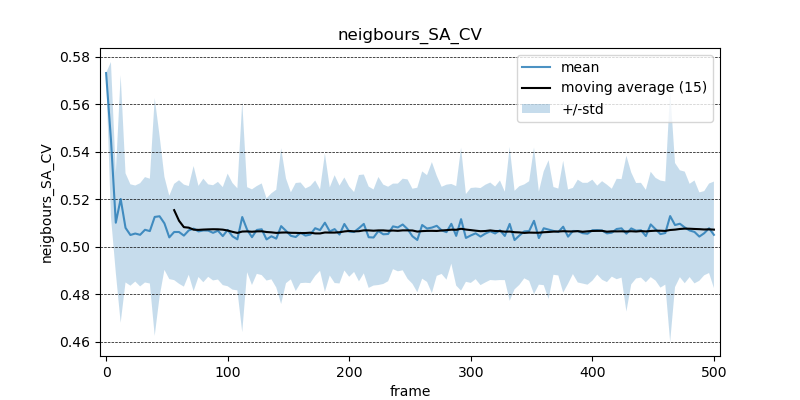

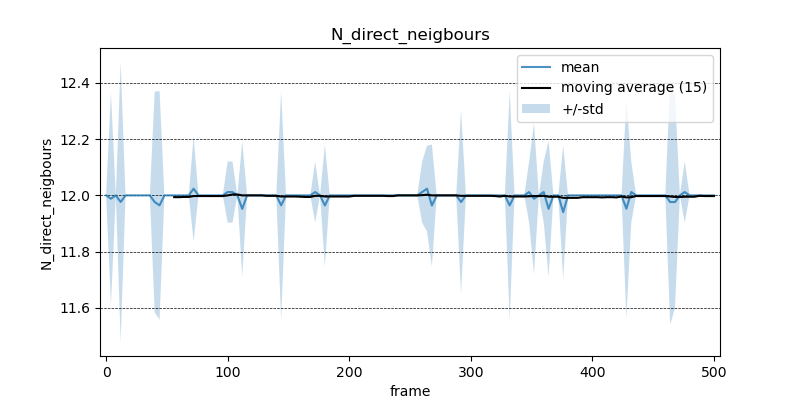

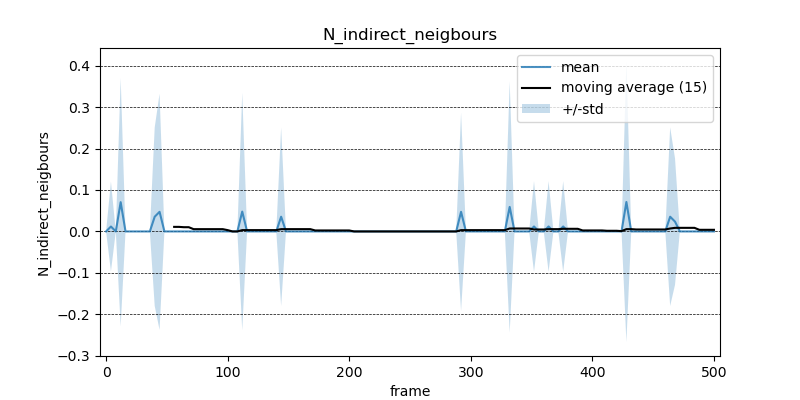

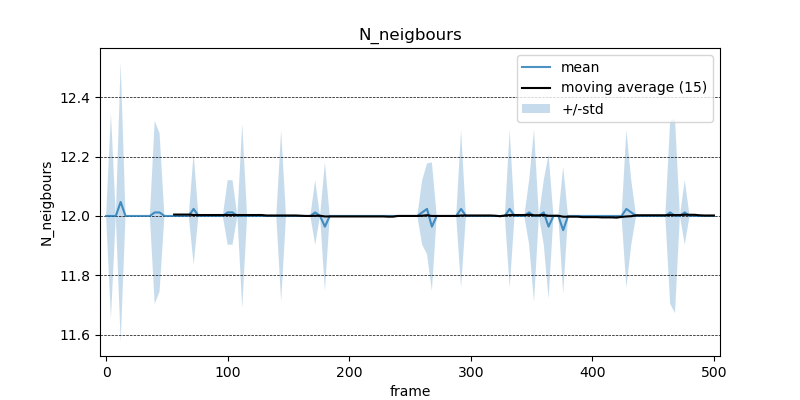

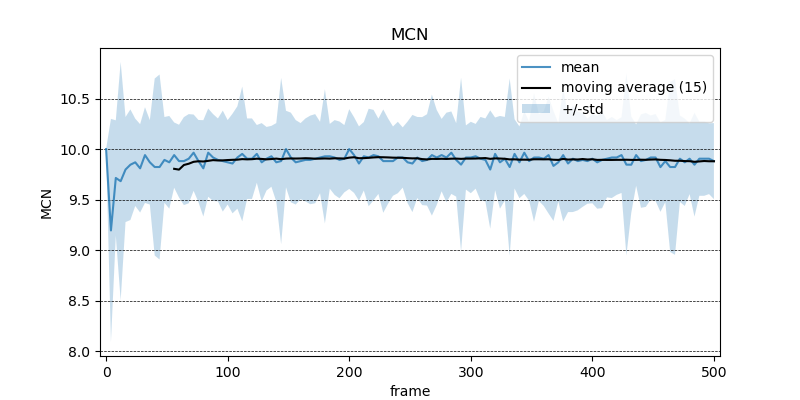

In [9]:
for descriptor in ['neigbours_SA_CV', 'N_direct_neigbours', 'N_indirect_neigbours', 'N_neigbours', 'MCN']:
    plt.figure(figsize=(8, 4))
    plt.title(descriptor)
    plt.grid(visible=True, axis='y', color='k', linestyle='--', linewidth=0.5)
    plt.plot(df_vdp_mean_std[(descriptor, 'mean')], alpha=0.8, label='mean')
    plt.plot(df_vdp_mean_std[(descriptor, 'mean')].rolling(ROLLING_MEAN_PERIODS).mean(),
             color='k', alpha=1.0, label=f'moving average ({ROLLING_MEAN_PERIODS})')
    plt.fill_between(
        N_FRAMES,
        df_vdp_mean_std[(descriptor, 'mean')] - df_vdp_mean_std[(descriptor, 'std')],
        df_vdp_mean_std[(descriptor, 'mean')] + df_vdp_mean_std[(descriptor, 'std')],
        alpha=0.25,
        label='+/-std'
    )
    plt.xlim(-5, N_FRAMES.max() + 5)
    plt.xlabel('frame')
    plt.ylabel(descriptor)
    plt.legend()
    plt.show()

In [10]:
fwsG = tn_analysis.get_filtered_weighted_static_graph(edge_weight_threshold=0.999)

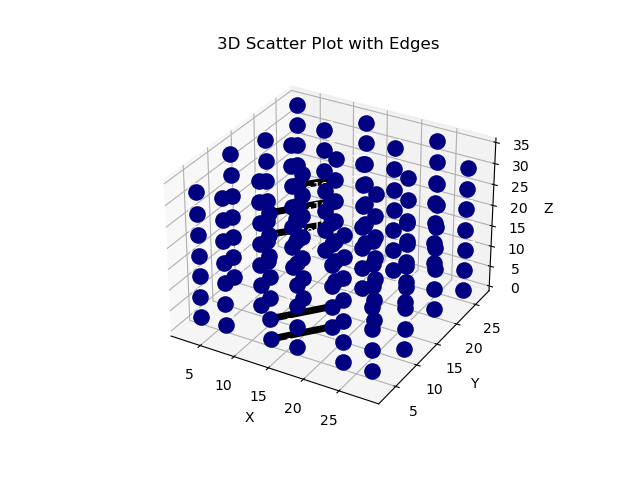

In [11]:
plot_graph_mpl(fwsG)

In [106]:
from scipy.spatial import Voronoi
import warnings

from collections import defaultdict

In [65]:
def solid_angle(center, coords):
    """
    Helper method to calculate the solid angle of a set of coords from the
    center.

    Args:
        center (3x1 array): Center to measure solid angle from.
        coords (Nx3 array): List of coords to determine solid angle.

    Returns:
        The solid angle.
    """
    # Compute the displacement from the center
    r = [np.subtract(c, center) for c in coords]

    # Compute the magnitude of each vector
    r_norm = [np.linalg.norm(i) for i in r]

    # Compute the solid angle for each tetrahedron that makes up the facet
    #  Following: https://en.wikipedia.org/wiki/Solid_angle#Tetrahedron
    angle = 0
    for i in range(1, len(r) - 1):
        j = i + 1
        tp = np.abs(np.dot(r[0], np.cross(r[i], r[j])))
        de = (
            r_norm[0] * r_norm[i] * r_norm[j]
            + r_norm[j] * np.dot(r[0], r[i])
            + r_norm[i] * np.dot(r[0], r[j])
            + r_norm[0] * np.dot(r[i], r[j])
        )
        my_angle = (0.5 * pi if tp > 0 else -0.5 * pi) if de == 0 else np.arctan(tp / de)
        angle += (my_angle if my_angle > 0 else my_angle + np.pi) * 2

    return angle

In [101]:
def calc_angles(ps1, ps2, ps3):

    vs1 = np.array(ps1) - ps2
    vs2 = np.array(ps3) - ps2
    a = np.array(list(map(np.linalg.norm, vs1))) * list(map(np.linalg.norm, vs2))
    a[a == 0] = None
    with warnings.catch_warnings():
        cos = np.array([np.dot(v1, v2) / a for v1, v2, a in zip(vs1, vs2, a)])
        cos[cos > 1] = 1.0
        cos[cos < -1] = - 1.0
        angles = np.arccos(cos)
        angles[angles > np.pi] = np.pi
    return angles


def are_collinear(vs, tol=0.01):

    if len(vs) < 2:
        return True
    v_0 = vs[0]
    for v in vs[1:]:
        if sum(abs(np.cross(v_0, v))) > tol:
            return False
    return True


def are_coplanar(vs, tol=0.01):

    if len(vs) < 3:
        return True
    v_1 = vs[0]
    for v in vs[1:]:
        if not are_collinear([v_1, v]):
            ab = np.cross(v_1, v)
            break
    else:
        return True
    for v in vs[1:]:
        if abs(np.dot(ab, v)) > tol:
            return False
    return True

def is_inside(vertices, pt, tol=0.001):

    inside = False
    n_v = len(vertices)
    centroid = sum(vertices) / n_v
    v1 = pt - centroid
    if sum(abs(v1)) < tol:
        return True
    v2, v3 = vertices[:2] - centroid
    norm = np.cross(v2, v3)
    norm /= np.linalg.norm(norm)
    if abs(np.dot(v1 / np.linalg.norm(v1), norm)) > tol:
        return False
    angles_sum = sum(calc_angles(vertices, [pt]*len(vertices), [*vertices[1:], vertices[0]])) / np.pi
    if abs(angles_sum - round(angles_sum)) < 1e-9:
        return True
    return inside

In [126]:
num_central = 30
OMEGA_THRESHOLD = 0.1

In [118]:
points = 10*np.random.randn(num_central, 3)
vdp = Voronoi(points)

In [120]:
vdp.ridge_dict

{(11, 3): [-1, 0, 10, 11, 1],
 (11, 7): [-1, 0, 2, 22, 21],
 (11, 17): [-1, 1, 8, 20, 21],
 (11, 18): [0, 2, 12, 10],
 (11, 8): [1, 11, 8],
 (11, 24): [2, 22, 19, 12],
 (11, 14): [8, 20, 19, 12, 10, 11],
 (11, 22): [19, 22, 21, 20],
 (24, 18): [2, 12, 17, 31, 29, 14, 4],
 (24, 7): [2, 22, 27, 34, 35, 15, 4],
 (24, 5): [4, 15, 14],
 (24, 14): [12, 19, 17],
 (24, 25): [14, 29, 35, 15],
 (24, 22): [17, 31, 28, 27, 22, 19],
 (24, 13): [27, 34, 28],
 (24, 27): [28, 34, 35, 29, 31],
 (14, 29): [7, 25, 18],
 (14, 18): [7, 39, 42, 13, 10, 12, 17, 18],
 (14, 12): [7, 39, 37, 9, 24, 25],
 (14, 8): [8, 11, 40, 37, 9],
 (14, 17): [8, 20, 24, 9],
 (14, 3): [10, 11, 40, 43, 13],
 (14, 5): [13, 43, 42],
 (14, 22): [17, 18, 25, 24, 20, 19],
 (14, 16): [37, 39, 42, 43, 40],
 (17, 8): [-1, 1, 8, 9, 59, 61, 47],
 (17, 15): [5, -1, 68, 66],
 (17, 13): [5, 26, 65, 66],
 (17, 7): [5, 26, 21, -1],
 (17, 12): [9, 59, 62, 23, 24],
 (17, 26): [-1, 47, 69, 68],
 (17, 22): [20, 21, 26, 65, 64, 23, 24],
 (17, 29):

In [121]:
vdp.points[[11, 8]].sum(axis=0) / 2

array([-9.67824522, -0.70562209,  2.05905983])

In [122]:
vdp.vertices[[0, 2, 12, 10]]

array([[-3.02433907, 26.5884633 , 19.56975272],
       [-3.17110693, 26.17923189, 18.88527436],
       [-4.72445089, 20.75232338, 12.33635366],
       [-4.19203232, 19.27128988, 16.70140455]])

In [127]:
p_neighbours_dict = defaultdict(list)
all_vertices = vdp.vertices

for (p1, p2), vertices in vdp.ridge_dict.items():

    if -1 not in vertices:

        # Get the solid angle of the face and check if it is not too small
        facets = [all_vertices[i] for i in vertices]
        p1_coords = points[p1]
        solid_angle_p1 = solid_angle(p1_coords, facets)
        if solid_angle_p1 < OMEGA_THRESHOLD:
            continue

        if is_inside(all_vertices[vertices], vdp.points[[p1, p2]].sum(axis=0) / 2):
            contact_type = "direct"
        else:
            contact_type = "indirect"

        p_neighbours_dict[p1].append((p2, solid_angle_p1, contact_type))

        # print(p1, p2, solid_angle_p1, contact_type)

In [142]:
dd = {
    p1: pd.DataFrame(neighbours, columns=['p2', 'SA', 'contact_type'])
    for p1, neighbours in p_neighbours_dict.items()
}

In [66]:
df_vdp = pd.read_csv('glu_HB.dir', sep='\t') # molecular and lattice molecular VDPs data

df_vdp['LVDP_CN_all'] = df_vdp['LVDP_Topology'].str.extract('\{(\d+)\/\d+\-').astype(int)
df_vdp['LVDP_indirect'] = df_vdp['CP composition'].str.findall('\*(\w{2})(\d*)').apply(lambda L: sum([int(d[1]) if d[1] != '' else 1 for d in L]))
df_vdp['LVDP_CN_direct'] = df_vdp['LVDP_CN_all'] - df_vdp['LVDP_indirect']
df_vdp['LVDP_Topology'] = df_vdp['LVDP_Topology'].str.extract(r'(\d+\/\d+)')

In [67]:
df_vdp_mean_std =  df_vdp.groupby('frame')[
    ['MVDP_CN', 'HB_CN', 'NZ', 'LVDP_Rsd', 'LVDP_V',
     'LVDP_S', 'LVDP_G3', 'Kp', 'Kc', 'RCMTop', 'LVDP_CN_all',
     'LVDP_indirect', 'LVDP_CN_direct']
].agg(['mean', 'std'])

In [68]:
tn_analysis.node_characteristics[tn_analysis.node_characteristics['frame'] == 500]

,frame,neigbours_SA_std,N_direct_neigbours,N_indirect_neigbours,N_neigbours,MCN
0,500,0.617286,13,2,15,3.0
1,500,0.568435,13,2,15,4.0
2,500,0.633734,13,2,15,5.0
3,500,0.729396,12,1,13,6.0
4,500,0.564565,11,3,14,5.0
...,...,...,...,...,...,...
147,500,0.658645,13,2,15,4.0
148,500,0.577267,13,1,14,6.0
149,500,0.764432,10,1,11,5.0
150,500,0.786841,10,2,12,3.0


In [69]:
df_vdp[df_vdp['frame'] == 500]

,frame,Atoms,MVDP_CN,HB_CN,NZ,LVDP_Rsd,LVDP_V,LVDP_S,LVDP_G3,Kp,Kc,RCMTop,LVDP_Topology,CP composition,LVDP_CN_all,LVDP_indirect,LVDP_CN_direct
75851,500,ZA1,13,5,5.92,3.886816,245.96342,215.49869,0.084354,0.299906,2.778492,0.567831,15/26,ZA10 *ZA ZA3 *ZA,15,2,13
75852,500,ZA2,14,3,6.21,3.828229,235.00779,208.15630,0.082635,0.386569,2.732555,0.448537,14/24,ZA14,14,0,14
75853,500,ZA3,15,4,5.30,3.749858,220.86812,201.35776,0.083206,0.327762,2.928528,0.179553,15/26,ZA14 *ZA,15,1,14
75854,500,ZA4,13,4,5.35,3.725335,216.56316,201.45898,0.086772,0.283553,3.238770,0.388455,14/24,ZA10 *ZA ZA2 *ZA,14,2,12
75855,500,ZA5,12,6,5.97,3.613635,197.66124,187.44342,0.082519,0.366087,2.630803,0.189142,12/20,ZA12,12,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75998,500,ZA148,12,5,6.39,3.649676,203.63455,191.10271,0.083819,0.341476,2.539195,0.377396,14/24,ZA8 *ZA ZA2 *ZA2 ZA,14,3,11
75999,500,ZA149,12,6,5.04,3.560317,189.04037,182.11861,0.081760,0.305378,3.009326,0.236946,13/22,ZA12 *ZA,13,1,12
76000,500,ZA150,10,5,4.74,3.484842,177.27114,181.70790,0.086764,0.254530,2.998532,0.478510,13/22,ZA8 *ZA ZA2 *ZA2,13,3,10
76001,500,ZA151,13,3,5.26,3.900469,248.56450,219.84422,0.086134,0.253733,4.181542,0.374969,13/22,ZA12 *ZA,13,1,12


In [70]:
df_vdp_mean_std[('HB_CN', 'mean')].loc[range(50, 1001, 50)]

frame
50      5.513158
100     5.460526
150     5.263158
200     5.328947
250     5.157895
300     4.986842
350     5.144737
400     5.118421
450     4.881579
500     5.131579
550     4.934211
600     5.236842
650     5.434211
700     5.078947
750     5.157895
800     5.276316
850     5.289474
900     5.118421
950     4.973684
1000    5.118421
Name: (HB_CN, mean), dtype: float64

In [72]:
tn_analysis.node_characteristics.groupby('frame')['MCN'].mean()#.plot()

frame
0       8.894737
50      5.500000
100     5.473684
150     5.644737
200     5.421053
250     5.394737
300     5.118421
350     5.328947
400     5.231788
450     5.236842
500     5.236842
550     5.394737
600     5.381579
650     5.157895
700     5.342105
750     5.171053
800     5.447368
850     5.473684
900     5.084967
950     5.355263
1000    5.486842
Name: MCN, dtype: float64